In [1]:
import sys
sys.path.append("..")
from VAE.vae import *

In [2]:
config_space = ConfigurationSpace(
                {'input_dropout': 0.1, 'intermediate_activation': "relu", 'intermediate_dimension': 30,
                'intermediate_layers': 3, 'latent_dimension': 3, 'learning_rate': 0.0001,
                'original_dim': 825000, 'solver': 'nadam', "tied": 1, "kld_weight": 0.1}
            )
config = config_space.get_default_configuration()

In [3]:
model = FIA_VAE(config)

In [4]:
model.summary()

Model: "fia_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_intermediate            │ ?                      │    24,750,631 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_mu (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_sigma (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_reparametrization        │ ?                      │   0 (unbuilt) │
│ (Sampling)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ ?                      │    25,575,683 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,575,683 (97.56 MB)

 Trainable params: 25,575,683 (97.56 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "../../runs/FIA/Sampled_Coms/merge_only"))
data = read_data(data_dir, verbosity=0)
X = np.random.normal(0.0, 1.0, size=(5, 825000))

In [8]:
model.fit(data, data, validation_split=0.2, batch_size=100, epochs=10, callbacks=[])

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - kl_loss: -0.0000e+00 - loss: 7.9721e-05 - reconstruction_loss: 7.9721e-05 - val_kl_loss: 1.2219e-06 - val_loss: 5.8291e-05 - val_reconstruction_loss: 5.8169e-05
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - kl_loss: 4.4703e-06 - loss: 4.2811e-05 - reconstruction_loss: 4.2364e-05 - val_kl_loss: 4.1723e-06 - val_loss: 3.0323e-05 - val_reconstruction_loss: 2.9906e-05
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step - kl_loss: 1.6689e-05 - loss: 7.7892e-05 - reconstruction_loss: 7.6223e-05 - val_kl_loss: 2.3842e-06 - val_loss: 2.9181e-05 - val_reconstruction_loss: 2.8943e-05
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step - kl_loss: 9.5367e-06 - loss: 4.2326e-05 - reconstruction_loss: 4.1373e-05 - val_kl_loss: 8.9407e-08 - val_loss: 1.7015e-05 - val_reconstruction_loss: 1.7006e-05
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - kl_loss: -0.0000e+00 - loss: 5.0149e-05 - reconstruction_loss: 5.0149e-05 - val_kl_loss: -0.0000e+00

## Saving

In [ ]:
keras.saving.save_model(model, "../../runs/VAE/training/test/test.keras")

/mnt/lustre/groups/link/linca945/.conda/envs/VAE/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [ ]:
model.save_weights("../../runs/VAE/training/test/test.weights.h5")

## Loading

In [ ]:
model2 = keras.saving.load_model("../../runs/VAE/training/test/test.keras")

ValueError: A total of 2 objects could not be loaded. Example error message for object <DenseTied name=dense_tied_4, built=True>:

Layer 'dense_tied_4' expected 1 variables, but received 0 variables during loading. Expected: ['bias']

List of objects that could not be loaded:
[<DenseTied name=dense_tied_4, built=True>, <Dense name=dense_4, built=True>]

In [ ]:
model2.load_weights("../../runs/VAE/training/test/test.weights.h5")

## Testing

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint( filepath="../../runs/VAE/training/test/test_{epoch}.keras",
                                                  save_best_only=True, monitor="val_loss",
                                                  verbose=1 )

In [ ]:
run = wandb.init( project="FIA_VAE",
                  name="VAE Test Jupyter",
                  dir="../../runs/VAE/training/test",
                  config=dict(config) )
wandb_cb = WandbMetricsLogger(log_freq="epoch", initial_global_step=0 + 1)

NameError: name 'wandb' is not defined

In [ ]:
mlflow.login()
mlflow.set_experiment(f"/Users/josua.carl@student.uni-tuebingen.de/FIA_VAE")
run = mlflow.start_run(run_name="VAE Test", nested=False)
mlflow_cb = mlflow.keras.MlflowCallback(run)

2024/04/18 18:05:37 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [ ]:
model2.fit(data, data, validation_split=0.2, batch_size=32, epochs=10, callbacks=[])

Epoch 1/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - kl_loss: -0.0000e+00 - loss: 1.3570e-05 - reconstruction_loss: 1.3570e-05

InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [32] vs. [22] [Op:AddV2] name: 

In [ ]:
loss, kl_loss, recon_loss = model2.evaluate(data, data, batch_size=68)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - kl_loss: 4.0531e-06 - loss: 1.1489e-05 - reconstruction_loss: 1.1084e-05


In [ ]:
prediction = pd.DataFrame(model2.predict(data))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [ ]:
plot_df = pd.DataFrame(prediction.loc[1].values, index=data.columns, columns=["inty"]).reset_index()
plot_df_2 = pd.DataFrame(data.iloc[1].values, index=data.columns, columns=["inty"]).reset_index()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

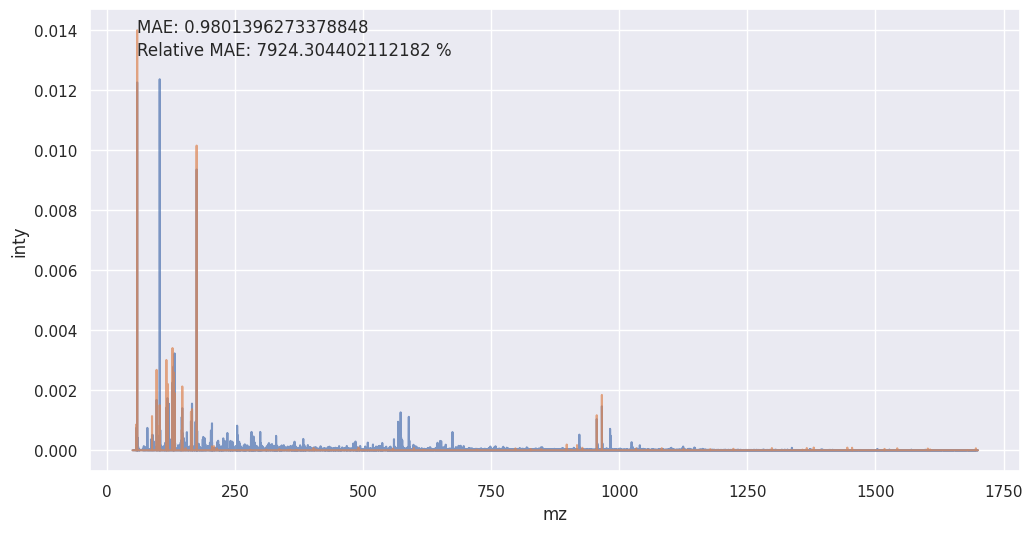

In [ ]:
mae = np.mean(np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) ))
rel_mae = mae / np.max(plot_df_2["inty"])

sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.annotate(f"MAE: {mae}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f"Relative MAE: {rel_mae *100} %", xy=(0.05, 0.90), xycoords='axes fraction')
plt.show()